In [1]:
from google.colab import drive
drive.mount('/content/drive')


import os
dataset_path = '/content/drive/My Drive/chest_xray/chest_xray'
print(os.listdir(dataset_path))

Mounted at /content/drive
['test', 'val', 'train']


In [2]:
# Setting up dataset paths
dataset_path = '/content/drive/MyDrive/chest_xray/chest_xray'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# Checking classes in each folder
print("Training data classes:", os.listdir(train_path))
print("Validation data classes:", os.listdir(val_path))
print("Testing data classes:", os.listdir(test_path))

# Counting images per class
train_normal = len(os.listdir(os.path.join(train_path, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_path, 'PNEUMONIA')))
print(f"Training data: NORMAL={train_normal}, PNEUMONIA={train_pneumonia}")

val_normal = len(os.listdir(os.path.join(val_path, 'NORMAL')))
val_pneumonia = len(os.listdir(os.path.join(val_path, 'PNEUMONIA')))
print(f"Validation data: NORMAL={val_normal}, PNEUMONIA={val_pneumonia}")

test_normal = len(os.listdir(os.path.join(test_path, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_path, 'PNEUMONIA')))
print(f"Testing data: NORMAL={test_normal}, PNEUMONIA={test_pneumonia}")

Training data classes: ['PNEUMONIA', 'NORMAL']
Validation data classes: ['PNEUMONIA', 'NORMAL']
Testing data classes: ['PNEUMONIA', 'NORMAL']
Training data: NORMAL=1341, PNEUMONIA=3885
Validation data: NORMAL=8, PNEUMONIA=8
Testing data: NORMAL=234, PNEUMONIA=390


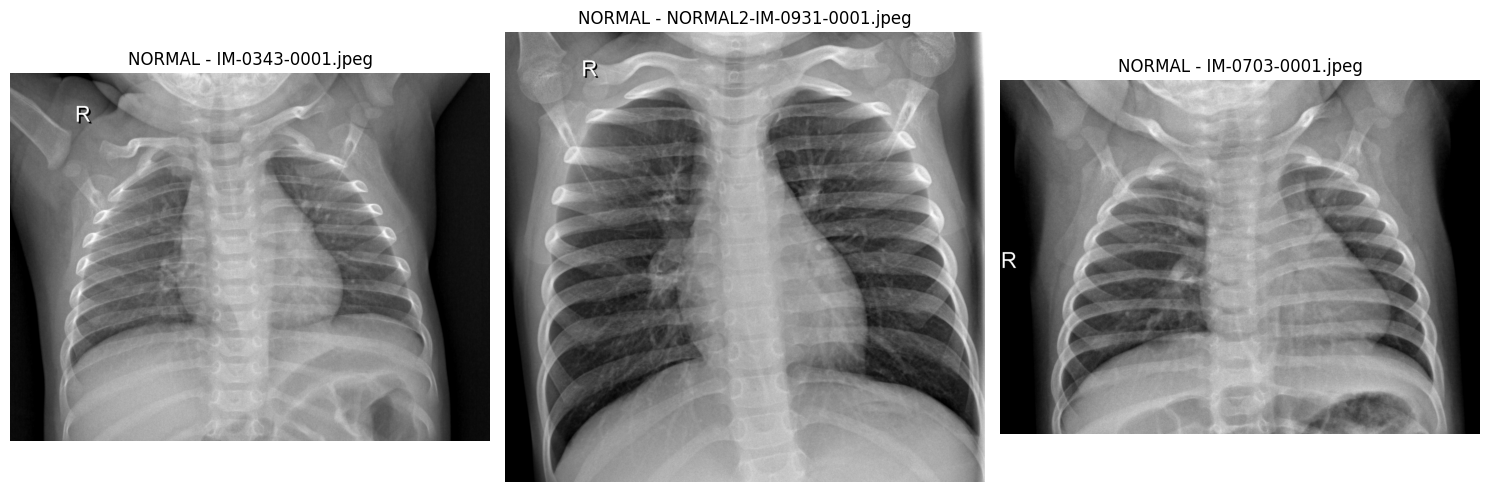

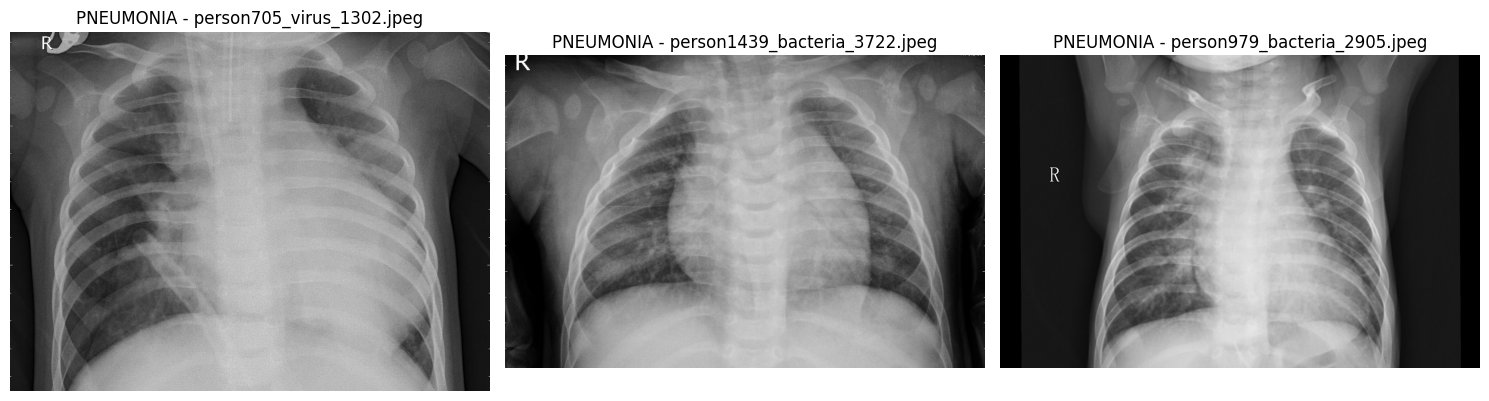

In [3]:
# Visualizing sample images
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

def show_random_images(class_name, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Get random images from the training set
    img_dir = os.path.join(train_path, class_name)
    img_files = os.listdir(img_dir)
    random_files = random.sample(img_files, num_images)

    for i, file in enumerate(random_files):
        img_path = os.path.join(img_dir, file)
        img = Image.open(img_path)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{class_name} - {file}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show sample images from each class
show_random_images('NORMAL')
show_random_images('PNEUMONIA')

In [4]:
# Importing necessary libraries for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting image parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Building the CNN model
def build_cnn_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (Normal vs Pneumonia)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = build_cnn_model()

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 51,672,097 (197.11 MB)

 Trainable params: 51,670,177 (197.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
# Setting up callbacks for model training
checkpoint = ModelCheckpoint(
    'pneumonia_detection_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7885 - loss: 0.5620 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to pneumonia_detection_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 3220s 20s/step - accuracy: 0.7888 - loss: 0.5614 - val_accuracy: 0.5000 - val_loss: 22.3754
Epoch 2/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 54:29 20s/step - accuracy: 0.8750 - loss: 0.2707

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8750 - loss: 0.2707 - val_accuracy: 0.5000 - val_loss: 22.6128
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.8815 - loss: 0.3104 
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 3172s 19s/step - accuracy: 0.8816 - loss: 0.3103 - val_accuracy: 0.5000 - val_loss: 39.2480
Epoch 4/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 46:58 17s/step - accuracy: 0.8750 - loss: 0.2776
Epoch 4: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8750 - loss: 0.2776 - val_accuracy: 0.5000 - val_loss: 39.4623
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9117 - loss: 0.2540 
Epoch 5: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 3192s 20s/step - accuracy: 0.9117 - loss: 0.2539 - val_accuracy: 0.5000 - val_loss: 19.4014
Epoch 6/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 52:29 19s/

163/163 ━━━━━━━━━━━━━━━━━━━━ 3280s 20s/step - accuracy: 0.9381 - loss: 0.1917 - val_accuracy: 0.6250 - val_loss: 0.6250
Epoch 10/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 59:30 22s/step - accuracy: 1.0000 - loss: 0.0430
Epoch 10: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 1.0000 - loss: 0.0430 - val_accuracy: 0.5625 - val_loss: 0.8744
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9461 - loss: 0.1737 
Epoch 11: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 3207s 20s/step - accuracy: 0.9461 - loss: 0.1737 - val_accuracy: 0.6250 - val_loss: 0.9708
Epoch 12/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 49:04 18s/step - accuracy: 0.9688 - loss: 0.3566
Epoch 12: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9688 - loss: 0.3566 - val_accuracy: 0.5000 - val_loss: 1.3594
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9501 - loss: 0.1452 
Epoch 13: 

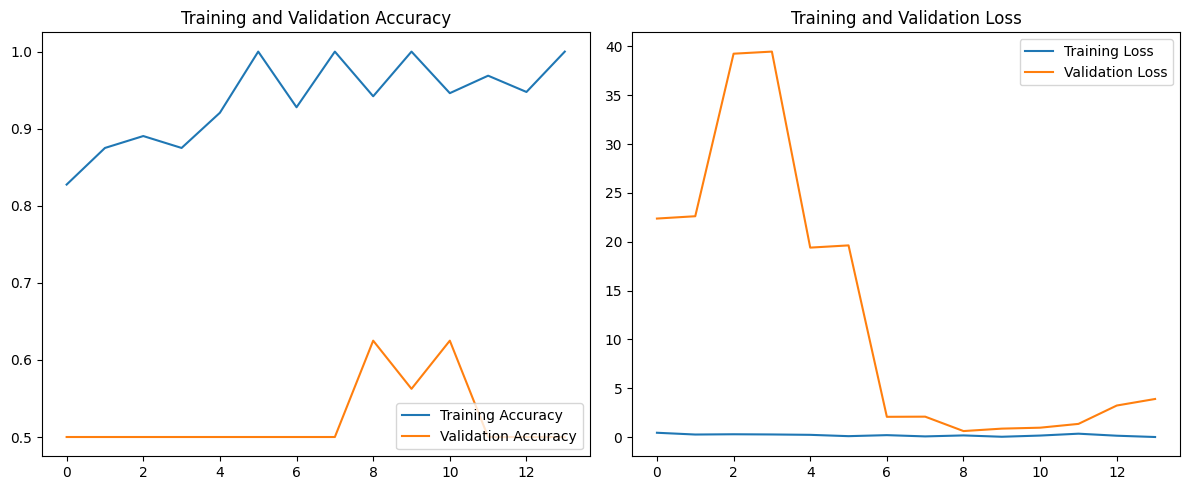

In [7]:
# Visualizing the training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 196s 10s/step - accuracy: 0.8887 - loss: 0.6408
Test Accuracy: 0.8253
Test Loss: 0.6302
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.70      0.93      0.80       234
   PNEUMONIA       0.95      0.76      0.84       390

    accuracy                           0.83       624
   macro avg       0.82      0.85      0.82       624
weighted avg       0.86      0.83      0.83       624



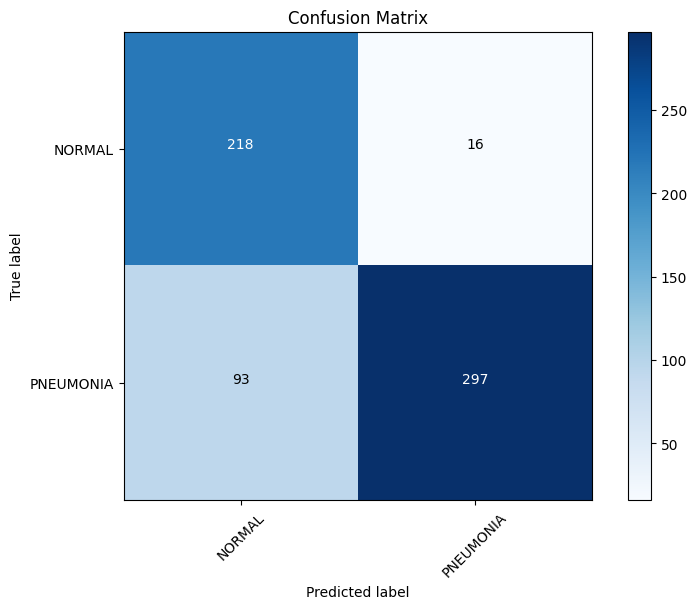

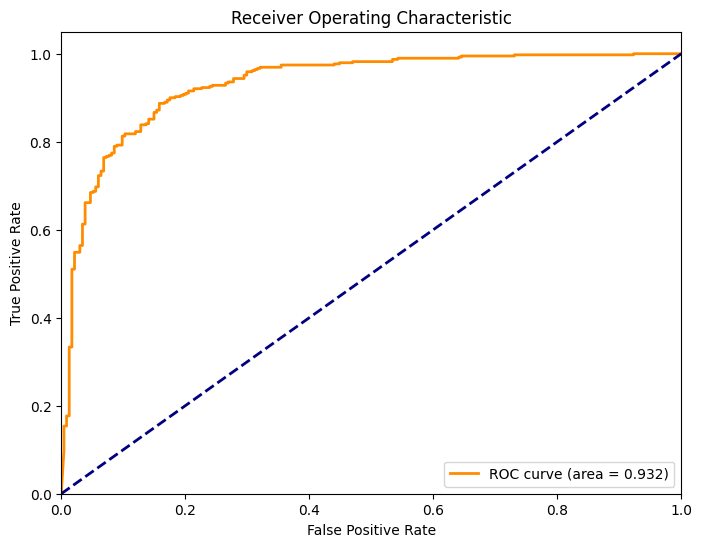

In [8]:
# Evaluating the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generating predictions on test data
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Calculating classification metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['NORMAL', 'PNEUMONIA']))

# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Calculate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
plot_confusion_matrix(cm, classes=['NORMAL', 'PNEUMONIA'])

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_roc_curve(y_true, y_pred)

In [12]:
def print_strategic_insights():
    """
    Print strategic insights from an AI Strategy Consultant perspective
    """
    print("\n" + "="*80)
    print("Strategic Analysis & Recommendations from an AI Strategy Consultant")
    print("="*80)

    print("""
Project Performance Summary:
- Test accuracy reached 82.53% with a pneumonia precision of 95%, demonstrating a reliable baseline CNN model.
- From a clinical perspective, the high precision in pneumonia detection indicates strong potential for AI-assisted diagnosis.
- The developed pipeline is scalable and applicable to other medical imaging tasks.

Strategic Implications:
1. Medical AI should focus on augmenting clinical decision-making rather than full automation.
2. Radiologists' time can be optimized, leading to greater operational efficiency in hospitals.
3. Establishes a foundational AI infrastructure that is adaptable to other diagnostic domains.

Actionable Recommendations:

1. Model Improvement:
   - Integrate transfer learning using advanced architectures (e.g., VGG16, ResNet50).
   - Address class imbalance through weighted loss functions and enhanced data augmentation.
   - Employ cross-validation techniques such as k-fold for robust evaluation.

2. Practical Enhancements:
   - Implement interpretability techniques like Grad-CAM to increase trust and transparency.
   - Develop intuitive interfaces that are accessible to clinical staff.
   - Design APIs to ensure seamless integration with existing hospital information systems (HIS).

3. Business & Clinical Strategy:
   - Conduct pilot studies in real-world clinical settings to validate the AI system's efficacy.
   - Perform ROI analysis to demonstrate cost-effectiveness of deployment.
   - Follow a phased implementation strategy, beginning with an MVP rollout.

4. Ethics & Regulatory Readiness:
   - Formulate a strategy to achieve medical device certification and regulatory compliance.
   - Establish strong data privacy protection mechanisms aligned with HIPAA or local regulations.
   - Implement monitoring systems for algorithmic bias and fairness.

Conclusion:
This project goes beyond a technical implementation—demonstrating real potential to generate tangible value in clinical environments.
To ensure successful deployment of medical AI, excellence in technology must be matched by seamless integration into clinical workflows,
clinician trust, and measurable impact on patient care. Going forward, strong collaboration among developers, medical professionals,
and strategic decision-makers will be critical to advancing the future of AI in healthcare.
    """)

# Add this line at the end of main() function
print_strategic_insights()


Strategic Analysis & Recommendations from an AI Strategy Consultant

Project Performance Summary:
- Test accuracy reached 82.53% with a pneumonia precision of 95%, demonstrating a reliable baseline CNN model.
- From a clinical perspective, the high precision in pneumonia detection indicates strong potential for AI-assisted diagnosis.
- The developed pipeline is scalable and applicable to other medical imaging tasks.

Strategic Implications:
1. Medical AI should focus on augmenting clinical decision-making rather than full automation.
2. Radiologists' time can be optimized, leading to greater operational efficiency in hospitals.
3. Establishes a foundational AI infrastructure that is adaptable to other diagnostic domains.

Actionable Recommendations:

1. Model Improvement:
   - Integrate transfer learning using advanced architectures (e.g., VGG16, ResNet50).
   - Address class imbalance through weighted loss functions and enhanced data augmentation.
   - Employ cross-validation techniq